In [144]:
import os

import nltk

from cltk.corpus.latin import latinlibrary

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

import matplotlib.pyplot as plt

import pickle

from pprint import pprint

In [68]:
TextArray = pickle.load(open("./data/text_array.p", "rb"))

In [69]:
TextArray[1]

('prose',
 'caesar/bc1.txt',
 'gratiam sequantur ut superioribus fecerint temporibus se sibi consilium capturum neque senatus auctoritati obtemperaturum habere se quoque ad caesaris gratiam atque amicitiam receptum in eandem sententiam loquitur scipio pompeio esse in animo rei publicae non deesse si senatus sequatur si cunctetur atque agat lenius nequiquam eius auxilium si postea uelit senatum imploraturum\nhaec scipionis oratio quod senatus in urbe habebatur pompeiusque aberat ex ipsius ore pompei mitti uidebatur dixerat aliquis leniorem sententiam ut primo m marcellus ingressus in eam orationem non oportere ante de ea re ad senatum referri quam dilectus tota italia habiti et exercitus conscripti essent quo praesidio tuto et libere senatus quae uellet decernere auderet ut m calidius qui censebat ut pompeius in suas prouincias proficisceretur ne qua esset armorum causa timere caesarem ereptis ab eo duabus legionibus ne ad eius periculum reseruare et retinere eas ad urbem pompeius uider

In [83]:
labels = [type for type, _, _ in TextArray]
texts = [text for _, _, text in TextArray]
titles = [title.replace('/', '_').replace('.txt','') for _, title, _ in TextArray]

In [71]:
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(texts)
vocab = np.array(vectorizer.get_feature_names())
dtm = dtm.toarray()

In [72]:
dtm

array([[48,  0,  0, ...,  0,  0,  0],
       [88,  0,  0, ...,  0,  0,  0],
       [40,  0,  0, ...,  0,  0,  0],
       ...,
       [11,  0,  0, ...,  0,  0,  0],
       [13,  0,  0, ...,  0,  0,  0],
       [15,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [73]:
dtm.shape

(124, 76821)

In [77]:
text_array_df = pd.DataFrame(dtm, columns=vocab, index=titles)
text_array_df.iloc[[0,25,50,100,123],:10]

,ab,abaci,abacis,abaco,abacorum,abactae,abactas,abacti,abacum,abacus
caesar_alex,48,0,0,0,0,0,0,0,0,0
vitruvius3,24,4,0,6,0,0,0,0,1,2
vergil_aen9,9,0,0,0,0,0,0,0,0,0
ovid_ovid.met10,8,0,0,0,0,0,0,0,0,0
ovid_ovid.tristia5,15,0,0,0,0,0,0,0,0,0


In [76]:
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)

In [79]:
rates_df = pd.DataFrame(rates, columns=vocab, index=titles)
rates_df.iloc[[0,25,50,100,123],:10]

,ab,abaci,abacis,abaco,abacorum,abactae,abactas,abacti,abacum,abacus
caesar_alex,4.725340,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
vitruvius3,6.286014,1.047669,0.0,1.571503,0.0,0.0,0.0,0.0,0.261917,0.523834
vergil_aen9,1.794974,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
ovid_ovid.met10,1.737242,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
ovid_ovid.tristia5,3.236246,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [82]:
prose_indices, verse_indices = [], []

for i, item in enumerate(TextArray):
    if item[0] == "prose":
        prose_indices.append(i)
    elif item[0] == "verse":
        verse_indices.append(i)

In [266]:
from sklearn.feature_selection import chi2
keyness, _ = chi2(dtm, labels)
ranking = np.argsort(keyness)[::-1]

In [86]:
ranking[0:10]

array([34091,  1055, 24660, 25003, 76456, 17191, 58732,  7546, 58562,
       46750])

In [87]:
vocab[ranking][0:10]

array(['in', 'ad', 'et', 'ex', 'ut', 'cum', 'quod', 'autem', 'qui', 'non'],
      dtype='<U22')

In [89]:
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed")
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

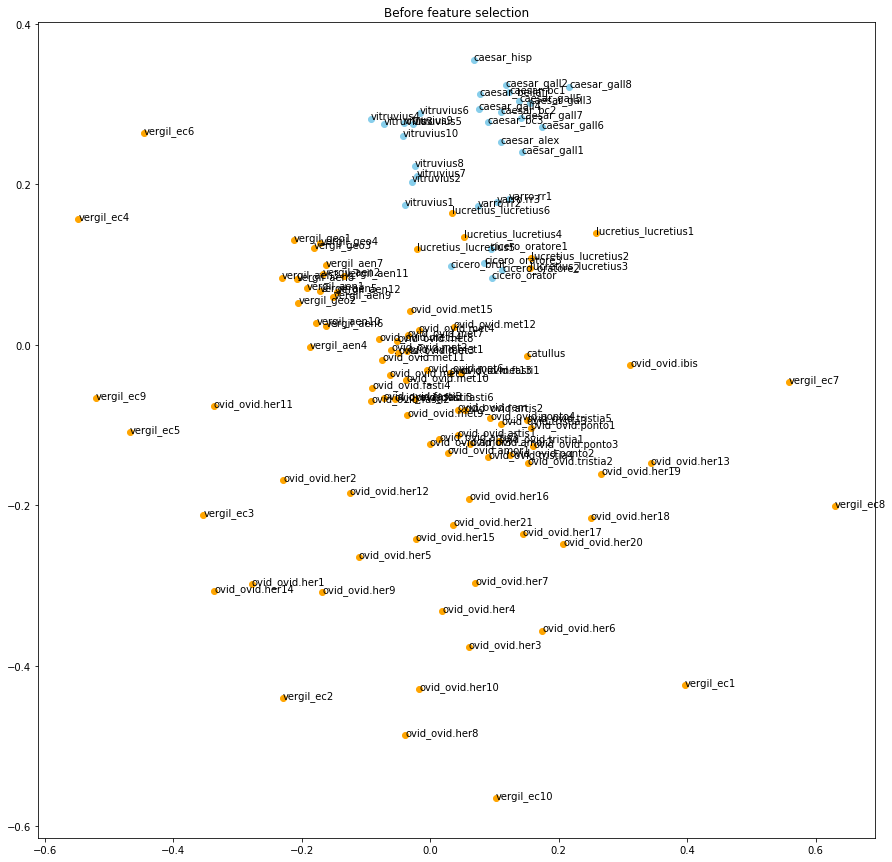

In [93]:
xs, ys = pos[:, 0], pos[:, 1]

names = [os.path.basename(fn).replace('.txt', '') for fn in titles]

plt.figure(figsize=(15,15))
for x, y, title, label in zip(xs, ys, titles, labels):
    color = 'orange' if label == 'verse' else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, title)


plt.title("Before feature selection")
plt.show()

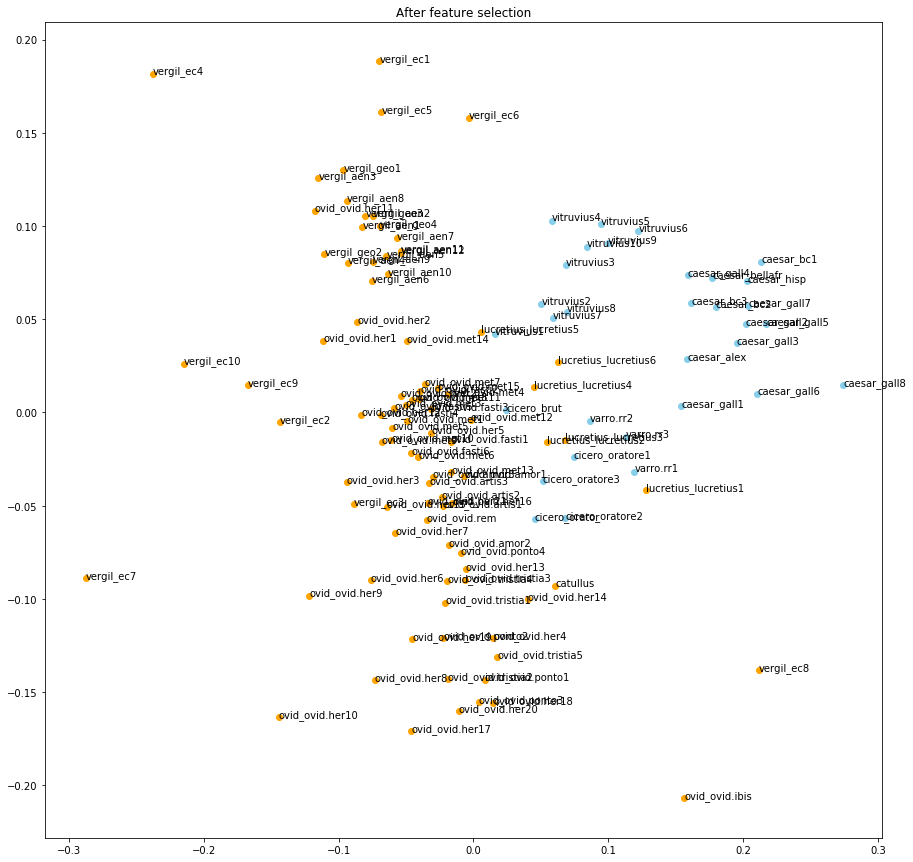

In [107]:
selected = np.argsort(keyness)[::-1][:50]
dtm_chi2 = dtm[:, selected]
dist = 1 - cosine_similarity(dtm_chi2)
mds = MDS(n_components=2, dissimilarity="precomputed")
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

plt.figure(figsize=(15,15))
for x, y, title, label in zip(xs, ys, titles, labels):
    color = 'orange' if label == 'verse' else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, title)

plt.title("After feature selection")
plt.show()

In [240]:
text_array_df.iloc[:10,selected[-10:]]

,uero,quo,omnibus,eos,quidem,castra,eis,omnium,castris,item
caesar_alex,11,51,29,9,5,27,12,11,21,1
caesar_bc1,19,26,33,19,2,33,16,21,37,4
caesar_bc2,14,12,14,6,10,18,7,13,13,3
caesar_bc3,15,34,38,16,5,38,16,18,48,8
caesar_bellafr,2,45,22,21,2,72,17,4,43,7
caesar_gall1,3,18,14,25,7,16,0,10,24,6
caesar_gall2,3,10,13,14,2,16,0,5,17,5
caesar_gall3,3,10,11,4,5,10,0,5,9,4
caesar_gall4,2,9,18,16,3,12,0,0,10,4
caesar_gall5,5,15,29,9,7,17,24,7,12,0


In [241]:
text_array_df.iloc[-10:,selected[-10:]]

,uero,quo,omnibus,eos,quidem,castra,eis,omnium,castris,item
ovid_ovid.ponto1,0,10,1,0,1,0,0,0,0,0
ovid_ovid.ponto2,1,8,2,0,5,2,0,0,0,0
ovid_ovid.ponto3,1,5,1,0,4,0,0,0,1,0
ovid_ovid.ponto4,0,8,1,0,3,0,0,0,0,0
ovid_ovid.rem,0,9,1,0,1,1,0,0,0,1
ovid_ovid.tristia1,3,10,0,0,3,0,0,0,0,0
ovid_ovid.tristia2,0,6,3,0,4,0,0,0,1,0
ovid_ovid.tristia3,1,9,0,0,2,0,0,0,0,0
ovid_ovid.tristia4,2,15,1,0,2,0,0,0,0,0
ovid_ovid.tristia5,2,10,1,0,1,0,0,0,0,0


In [242]:
text_array_df.loc[:,['uxor','coniunx']]

,uxor,coniunx
caesar_alex,0,0
caesar_bc1,0,0
caesar_bc2,0,0
caesar_bc3,0,0
caesar_bellafr,0,0
caesar_gall1,0,0
caesar_gall2,0,0
caesar_gall3,0,0
caesar_gall4,0,0
caesar_gall5,0,0


In [112]:
prose_index = [i for i, item in enumerate(TextArray) if item[0] == 'prose']
verse_index = [i for i, item in enumerate(TextArray) if item[0] == 'verse']

In [258]:
p_sum = text_array_df.iloc[prose_index].sum().tolist()
v_sum = text_array_df.iloc[verse_index].sum().tolist()

In [280]:
type_df = pd.DataFrame(list(zip(p_sum, v_sum)), columns = ['prose', 'verse'], index=vocab)

In [281]:
type_df['poeticness'] = type_df['verse'] / (type_df['prose'] + type_df['verse'])

In [282]:
from sklearn.preprocessing import minmax_scale
type_df['keyness_scaled'] = minmax_scale(keyness)


In [287]:
type_df.sort_values(['keyness_scaled'], ascending=[0])

,prose,verse,poeticness,keyness_scaled
in,7904,4623,0.369043,1.000000e+00
ad,3839,1373,0.263431,6.851136e-01
et,8701,8843,0.504047,5.699817e-01
ex,2334,572,0.196834,4.957189e-01
ut,3383,1818,0.349548,4.597293e-01
cum,3412,1884,0.355740,4.534687e-01
quod,2798,1448,0.341027,3.917925e-01
autem,1272,60,0.045045,3.713801e-01
qui,2212,1065,0.324992,3.270509e-01
non,3337,2717,0.448794,2.986632e-01


In [248]:
type_df.loc['coniunx']

prose          0.000000
verse         53.557011
poeticness     1.000000
Name: coniunx, dtype: float64

In [249]:
type_df.loc['uxor']

prose          0.163239
verse         21.104337
poeticness     0.992325
Name: uxor, dtype: float64

In [152]:
type_df.loc['eis']

prose         291.000000
verse           1.000000
poeticness      0.003425
Name: eis, dtype: float64

In [149]:
type_df.loc['libellum']

prose         3.0
verse         3.0
poeticness    0.5
Name: libellum, dtype: float64

## Mapping 'poeticness' in narrative space

In [156]:
# Script for preprocessing texts

import html
import re
import string
from cltk.stem.latin.j_v import JVReplacer

def preprocess(text):
    
    replacer = JVReplacer()
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
        
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j    
    
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
    
    return text.strip()

In [158]:
odes_tokens = preprocess("""Ne forte credas interitura quae
longe sonantem natus ad Aufidum
non ante volgatas per artis
verba loquor socianda chordis:
non, si priores Maeonius tenet
sedes Homerus, Pindaricae latent
Ceaeque et Alcaei minaces
Stesichorique graves Camenae

nec siquid olim lusit Anacreon
delevit aetas; spirat adhuc amor
vivuntque conmissi calores
Aeoliae fidibus puellae.

non sola comptos arsit adulteri
crinis et aurum vestibus inlitum
mirata regalisque cultus
et comites Helene Lacaena

primusve Teucer tela Cydonio
direxit arcu; non semel Ilios
vexata; non pugnavit ingens
Idomeneus Sthenelusve solus

dicenda Musis proelia; non ferox
Hector vel acer Deiphobus gravis
excepit ictus pro pudicis
coniugibus puerisque primus.

vixere fortes ante Agamemnona
multi; sed omnes inlacrimabiles
urgentur ignotique longa
nocte, carent quia vate sacro.

paullum sepultae distat inertiae
celata virtus. non ego te meis
chartis inornatum silebo,
totve tuos patiar labores

inpune, Lolli, carpere lividas
obliviones. est animus tibi
rerumque prudens et secundis
temporibus dubiisque rectus,

vindex avarae fraudis et abstinens
ducentis ad se cuncta pecuniae,
consulque non unius anni,
sed quotiens bonus atque fidus
iudex honestum praetulit utili,
reiecit alto dona nocentium
voltu, per obstantis catervas
explicuit sua victor arma.

non possidentem multa vocaveris
recte beatum; rectius occupat
nomen beati qui deorum
muneribus sapienter uti

duramque callet pauperiem pati
peiusque leto flagitium timet,
non ille pro caris amicis
aut patria timidus perire.""").split()

In [161]:
print(odes_tokens[:100])

['ne', 'forte', 'credas', 'interitura', 'quae', 'longe', 'sonantem', 'natus', 'ad', 'aufidum', 'non', 'ante', 'uolgatas', 'per', 'artis', 'uerba', 'loquor', 'socianda', 'chordis', 'non', 'si', 'priores', 'maeonius', 'tenet', 'sedes', 'homerus', 'pindaricae', 'latent', 'ceaeque', 'et', 'alcaei', 'minaces', 'stesichorique', 'graues', 'camenae', 'nec', 'siquid', 'olim', 'lusit', 'anacreon', 'deleuit', 'aetas', 'spirat', 'adhuc', 'amor', 'uiuuntque', 'conmissi', 'calores', 'aeoliae', 'fidibus', 'puellae', 'non', 'sola', 'comptos', 'arsit', 'adulteri', 'crinis', 'et', 'aurum', 'uestibus', 'inlitum', 'mirata', 'regalisque', 'cultus', 'et', 'comites', 'helene', 'lacaena', 'primusue', 'teucer', 'tela', 'cydonio', 'direxit', 'arcu', 'non', 'semel', 'ilios', 'uexata', 'non', 'pugnauit', 'ingens', 'idomeneus', 'sthenelusue', 'solus', 'dicenda', 'musis', 'proelia', 'non', 'ferox', 'hector', 'uel', 'acer', 'deiphobus', 'grauis', 'excepit', 'ictus', 'pro', 'pudicis', 'coniugibus', 'puerisque']


In [251]:
odes_score = []

for token in odes_tokens:
    if token in vocab:
        odes_score.append(type_df.loc[token][2]-.5)
    else:
        odes_score.append(0)

print(odes_score[:25])

[0.16774137890586593, 0.412557268000581, 0.5, 0.32014421023041284, 0.17279094764466474, 0.20875069328756313, 0.5, 0.30669880328441257, -0.06479346394377533, 0, 0.2151864863763444, 0.31862374345252076, 0, 0.311097223835358, 0.08569590058299048, 0.44372139373198904, 0.40724179380424574, 0, 0.5, 0.2151864863763444, 0.24670536982641234, 0.05499064403716114, 0, 0.4532205652577499, 0.3321667563739473]


In [252]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [264]:
odes_score_running = running_mean(odes_score, 5)

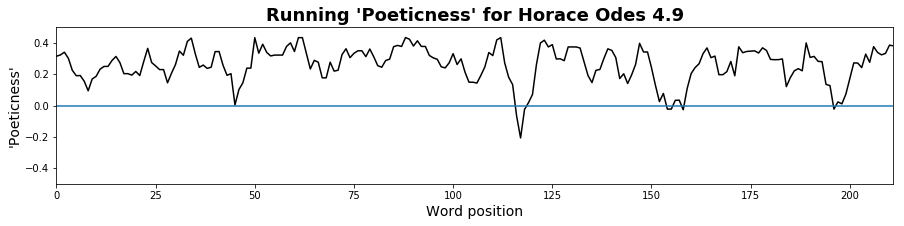

In [265]:
fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(odes_score_running, color="k")

t =  plt.title('Running \'Poeticness\' for Horace Odes 4.9',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)
ax.set_xlim(0,len(odes_score_running)-1)

ax.set_xlabel('Word position', fontsize = 14)
ax.set_ylabel('\'Poeticness\'', fontsize = 14)
plt.show()

In [238]:
def running_poeticness(tokens, window):
    scores = []

    for token in tokens:
        if token in vocab:
            scores.append(type_df.loc[token][2]-.5)
        else:
            scores.append(0)

    return running_mean(scores, window)


def plot_running_poeticness(running_scores, title, length=None):
    
    if not length:
        length = len(running_scores)-1
        
    fig = plt.figure()
    fig.set_size_inches(15,3)
    ax = fig.add_subplot(111)
    ax.plot(running_scores, color="k")

    t =  plt.title(f'Running \'Poeticness\' for {title}',fontsize = 18, fontweight = "bold")
    t.set_y(1.05)
    fig.subplots_adjust(top=0.85)

    ax.axhline(y=0)

    ax.xaxis.labelpad = 10 
    ax.yaxis.labelpad = 10 

    ax.set_ylim(-.5,.5)
    ax.set_xlim(0,length)

    ax.set_xlabel('Word position', fontsize = 14)
    ax.set_ylabel('\'Poeticness\'', fontsize = 14)
    plt.show()

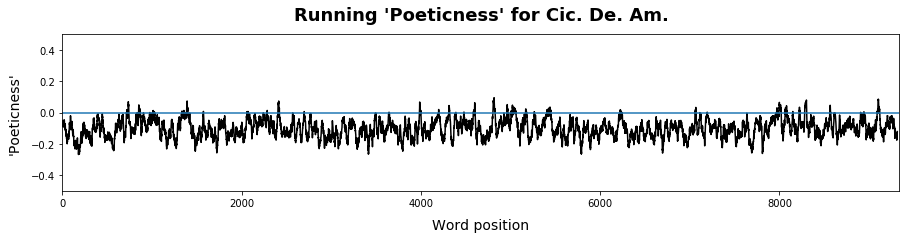

In [206]:
amicitia_tokens = preprocess(latinlibrary.raw('cicero/amic.txt')).split()
running_scores = running_poeticness(amicitia_tokens, 25)
plot_running_poeticness(running_scores, 'Cic. De. Am.')

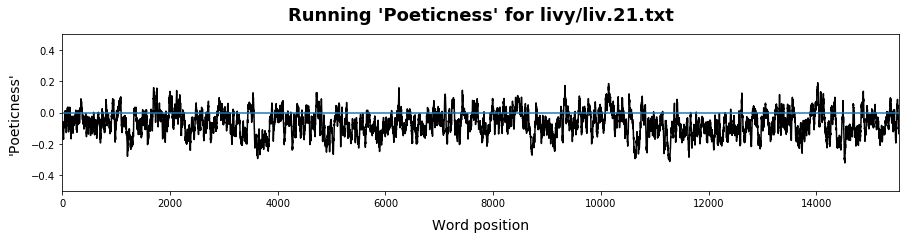

In [219]:
fileid = 'livy/liv.21.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

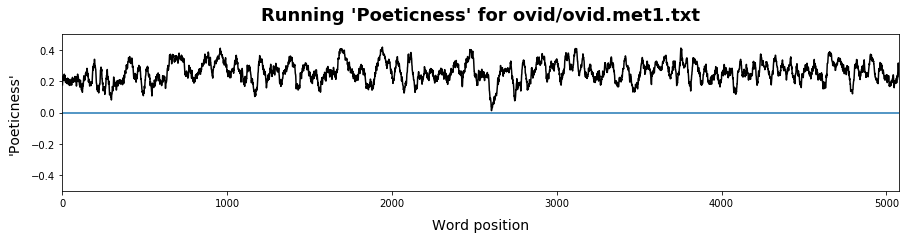

In [220]:
fileid = 'ovid/ovid.met1.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

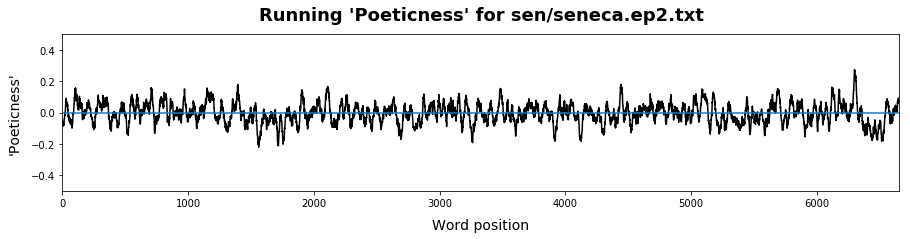

In [213]:
fileid = 'sen/seneca.ep2.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

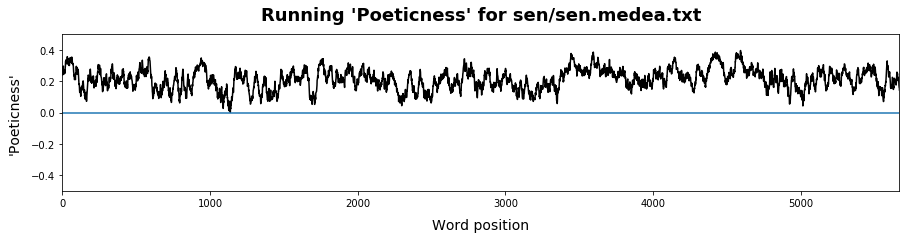

In [214]:
fileid = 'sen/sen.medea.txt'
tokens = preprocess(latinlibrary.raw(fileid)).split()
running_scores = running_poeticness(tokens, 25)
plot_running_poeticness(running_scores, fileid)

In [233]:
lucan = [file for file in latinlibrary.fileids() if 'lucan/' in file]
lucan = sorted(lucan, key=lambda x : int(" ".join(re.findall(r'\d+',x))))

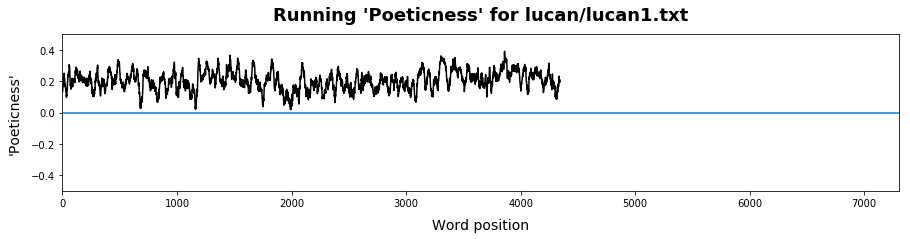

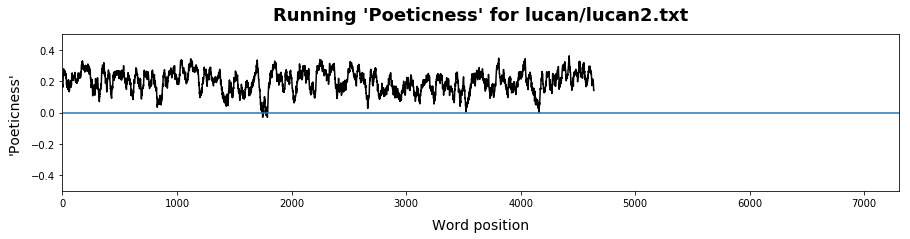

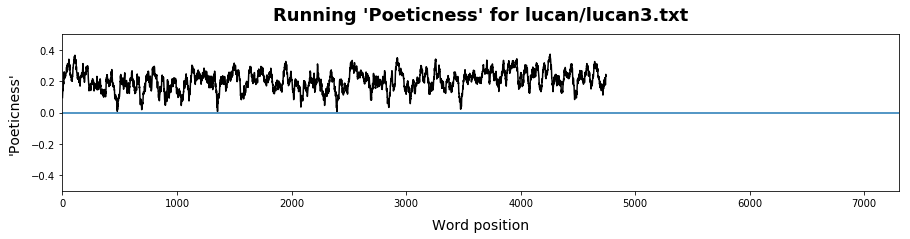

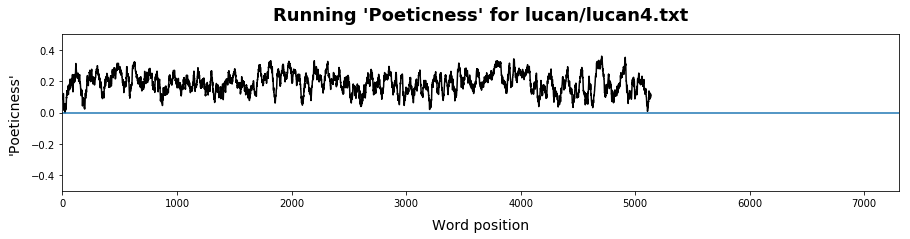

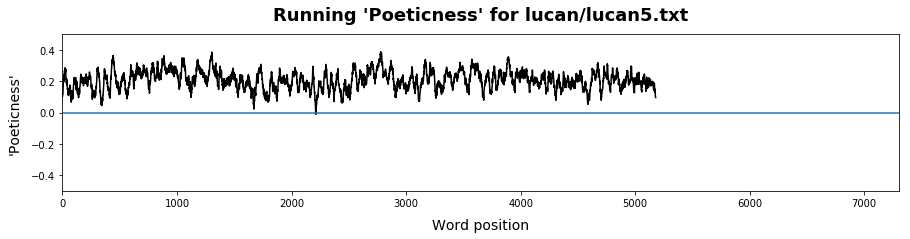

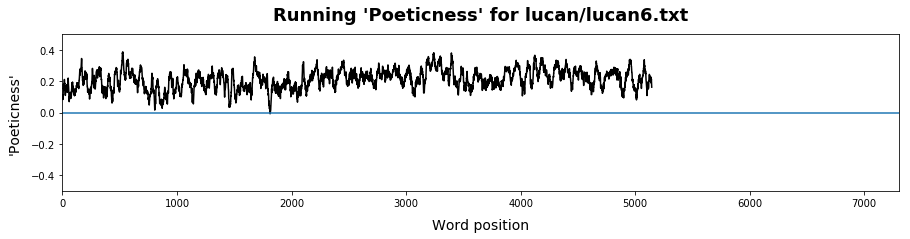

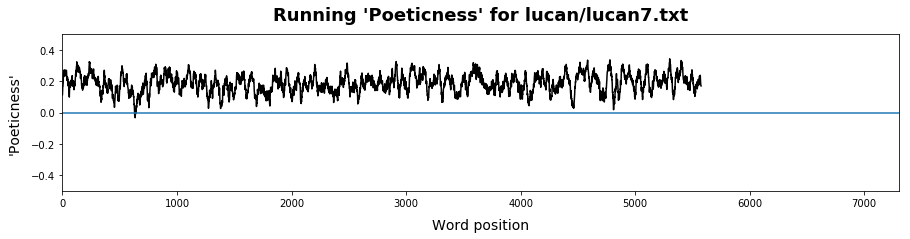

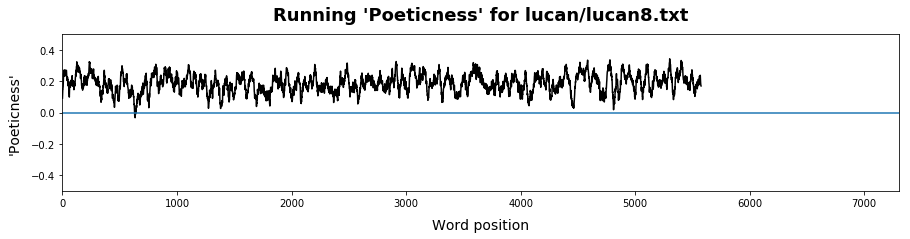

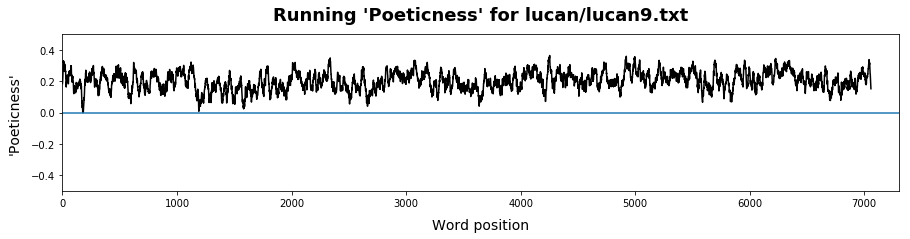

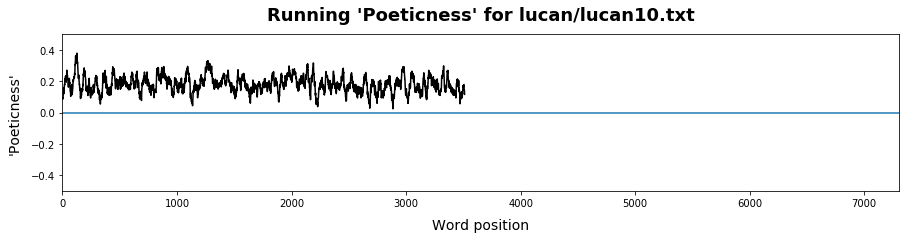

In [239]:
length = max([len(latinlibrary.raw(text).split()) for text in lucan])

for book in lucan:
    tokens = preprocess(latinlibrary.raw(book)).split()
    running_scores = running_poeticness(tokens, 25)
    plot_running_poeticness(running_scores, book, length=length)